# This script implements a simple baseline-CNN model for the Music Genre Classification task.

In [0]:
!pip install --upgrade tensorflow
!pip install --upgrade keras

     |████████████████████████████████| 86.3MB 49kB/s 
     |████████████████████████████████| 450kB 42.5MB/s 
     |████████████████████████████████| 3.8MB 32.1MB/s 
     |████████████████████████████████| 81kB 10.0MB/s 
ERROR: tensorboard 2.0.2 has requirement grpcio>=1.24.3, but you'll have grpcio 1.15.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement google-auth~=1.4.0, but you'll have google-auth 1.10.0 which is incompatible.
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
  Found existing installation: google-auth 1.4.2
    Uninstalling google-auth-1.4.2:
      Successfully uninstalled google-auth-1.4.2
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
  Found existing installation: tensorflow 1.15.0
    Uninstalling tensorflow-1.15.0:
      Successfully uninstall

     |████████████████████████████████| 378kB 2.5MB/s 
  Found existing installation: Keras 2.2.5
    Uninstalling Keras-2.2.5:
      Successfully uninstalled Keras-2.2.5


In [0]:
# System/zip-handling imports
import os, sys
import zipfile

# Imports tensorflow
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, regularizers
import keras 
from keras.layers import *
from keras.models import *
# Imports image handling
import cv2
import numpy as np
import skimage

# For generating training and test data
import random

# Save training progress
import csv
from datetime import datetime
from shutil import copyfile  # Making copy of this file instance (including param settings used)


Using TensorFlow backend.


# Get sorted list of training file names:

In [0]:
# Get access to zip-archive
archive = zipfile.ZipFile('../data/spectrograms.zip', 'r')
imgdata = archive.read('spectrograms/spectrogram_0000.png')

files = sorted([f for f in archive.namelist()[1:] if f.startswith('spectrograms/') and f.endswith('.png')])

print(files)

['spectrograms/spectrogram_0000.png', 'spectrograms/spectrogram_0001.png', 'spectrograms/spectrogram_0002.png', 'spectrograms/spectrogram_0003.png', 'spectrograms/spectrogram_0004.png', 'spectrograms/spectrogram_0005.png', 'spectrograms/spectrogram_0006.png', 'spectrograms/spectrogram_0007.png', 'spectrograms/spectrogram_0008.png', 'spectrograms/spectrogram_0009.png', 'spectrograms/spectrogram_0010.png', 'spectrograms/spectrogram_0011.png', 'spectrograms/spectrogram_0012.png', 'spectrograms/spectrogram_0013.png', 'spectrograms/spectrogram_0014.png', 'spectrograms/spectrogram_0015.png', 'spectrograms/spectrogram_0016.png', 'spectrograms/spectrogram_0017.png', 'spectrograms/spectrogram_0018.png', 'spectrograms/spectrogram_0019.png', 'spectrograms/spectrogram_0020.png', 'spectrograms/spectrogram_0021.png', 'spectrograms/spectrogram_0022.png', 'spectrograms/spectrogram_0023.png', 'spectrograms/spectrogram_0024.png', 'spectrograms/spectrogram_0025.png', 'spectrograms/spectrogram_0026.png', 

# JFF: Get a feeling for the nature of the training and evaluation data:

Type of image:
<class 'numpy.ndarray'>
Dimension of a single image file:
(128, 128, 3)


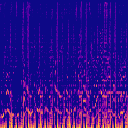

In [0]:
# Interpret image-data as image
from google.colab.patches import cv2_imshow
image = cv2.imdecode(np.frombuffer(imgdata, dtype=np.uint8), 1)

# Print some specs...
print('Type of image:')
print(type(image))
print('Dimension of a single image file:')
print(image.shape)

# Show image visually (press any key in opening window in order to proceed in code...)
cv2_imshow(image)
cv2.waitKey(0)
cv2.destroyAllWindows()

# Read in both training and testing data from zip archive:

In [0]:
data_set = []
# Data storage
combined_data_rnn = np.empty([1, 128, 128])

combined_data_cnn = np.empty([1,128,128])
# Read in images & store processed instances
for f_name in files:
    # Get image data from zip file
    zip_img_data = archive.read(f_name)
    image = cv2.imdecode(np.frombuffer(zip_img_data, dtype=np.uint8), 1)
    
    # Normalize image's colors to range [0, 1]
    image = image / 255.0
    
    image_rnn = np.rot90(image, 3)
    #cv2.imshow("Normalized Image", image)
    #cv2.waitKey(0)

    # Grayscale image
    gray_image = skimage.color.rgb2gray(image)
    gray_image_rnn = skimage.color.rgb2gray(image_rnn)
    #cv2.imshow("Grayscale Image", gray_image)
    #cv2.waitKey(0)
    #cv2.destroyAllWindows()

    # Store grayscaled image
    combined_data_cnn = np.append(combined_data_cnn,[gray_image],axis=0)
    combined_data_rnn = np.append(combined_data_rnn, [gray_image_rnn], axis=0)
    
# Remove initial, empty datapoint
combined_data_rnn = combined_data_rnn[1:, :, :]

combined_data_cnn = combined_data_cnn[1:,:,:]
print('Done reading in... Shape of data array rnn:')
print(combined_data_rnn.shape)

print('Done reading in... Shape of data array cnn:')
print(combined_data_cnn.shape)

print('Done.')

Done reading in... Shape of data array rnn:
(2000, 128, 128)
Done reading in... Shape of data array cnn:
(2000, 128, 128)
Done.


# Read in labels:

In [0]:
labels_path = '/labels.txt'

combined_labels = np.empty([1])

with open(labels_path, 'r') as file:
    for line in file:
        combined_labels = np.append(combined_labels, [int(line)])

# Remove initial, empty datapoint
combined_labels = combined_labels[1:] 
print(combined_labels)

[0. 0. 0. ... 9. 9. 9.]




# Divide data into train and test data:

------------------------------------------------------
Training data will be contained in:    training_data
Tetsing  data will be contained in:    testing_data

Training labels will be contained in:  training_labels
Tetsing  labels will be contained in:  testing_labels

In [0]:

# Get set of test-indices which indicates the training data points that have to be reserved for training
percentage_test_data = 0.2
population = range(len(combined_labels))
nr_samples = int(percentage_test_data * len(combined_labels))

test_indices = random.sample(population, nr_samples)
test_indices = sorted(test_indices)

print('Nr. test indices: ' + str(len(test_indices)))
print('Test indices: ' + str(test_indices))


# Split data into training- and test data, respectively - Preparation: Create empty arrays in which to later insert data
test_len = len(test_indices)
train_len = len(combined_labels)-len(test_indices)
training_data, training_labels = np.empty([train_len, 128, 128]), np.empty([train_len])
testing_data, testing_labels = np.empty([test_len, 128, 128]), np.empty([test_len])

training_data_cnn = np.empty([train_len, 128, 128])

testing_data_cnn = np.empty([test_len,128,128])
#combined_data_Ts = np.empty([,128,128,1])


combined_data_flat = np.empty([train_len + test_len,128*128]) 
test_idx_list_idx = 0
i = 0



'''
#################################################    SVM   ########################################################################
for data_idx in range(len(combined_labels)):
  combined_data_flat[data_idx,:] = combined_data[data_idx, :, :].flatten()

print("Combined Data shape ",combined_data_flat.shape)

###########################################################################################################################

'''
# Iterate through all data and assign each data point either to training data or testing data
for data_idx in range(len(combined_labels)):
    #combined_data_Ts = np.reshape(combined_data[data_idx],(1,128,128))

    if test_idx_list_idx < nr_samples and data_idx == test_indices[test_idx_list_idx]:
        testing_data[test_idx_list_idx, :, :] = combined_data_rnn[data_idx, :, :]
        training_data_cnn[test_idx_list_idx, :, :] = combined_data_cnn[data_idx,:,:]
        #testing_data[test_idx_list_idx, :, :] = combined_data_Ts
        testing_labels[test_idx_list_idx] = combined_labels[data_idx]
        test_idx_list_idx += 1
        
    else:
        
        training_data[i, :, :] = combined_data_rnn[data_idx, :, :]
        training_data_cnn[test_idx_list_idx, :, :] = combined_data_cnn[data_idx,:,:]
        #training_data[test_idx_list_idx, :, :] = combined_data_Ts
        training_labels[i] = combined_labels[data_idx]
        i += 1
        

training_data = training_data.reshape([len(training_labels), 128, 128])

testing_data = testing_data.reshape([len(testing_labels),  128, 128])

training_data_cnn = training_data.reshape([len(training_labels), 128, 128,1])
        
testing_data_cnn = testing_data.reshape([len(testing_labels),  128, 128,1])
print('Final:')
print(training_data.shape)
print(training_labels.shape)
print(testing_data.shape)
print(testing_labels.shape)

print(training_data_cnn.shape)

print(testing_data_cnn.shape)


Nr. test indices: 400
Test indices: [2, 13, 14, 20, 25, 29, 36, 44, 49, 52, 75, 79, 81, 82, 87, 88, 90, 91, 93, 98, 99, 108, 109, 112, 116, 121, 125, 128, 134, 141, 148, 156, 161, 163, 164, 171, 175, 176, 177, 178, 179, 191, 199, 205, 207, 212, 223, 231, 233, 234, 241, 244, 246, 250, 262, 263, 305, 306, 308, 309, 314, 319, 328, 332, 337, 339, 342, 343, 349, 359, 367, 368, 369, 381, 388, 392, 397, 398, 407, 410, 416, 425, 434, 438, 440, 451, 457, 472, 473, 474, 483, 486, 490, 496, 505, 508, 509, 511, 517, 521, 525, 526, 528, 529, 530, 531, 535, 538, 539, 550, 560, 563, 567, 573, 576, 580, 587, 592, 595, 597, 616, 618, 619, 626, 631, 645, 652, 666, 667, 671, 673, 676, 677, 679, 685, 694, 700, 704, 706, 714, 723, 730, 737, 738, 739, 748, 751, 754, 761, 764, 768, 778, 780, 786, 789, 794, 798, 799, 806, 808, 810, 814, 818, 821, 824, 828, 832, 837, 852, 857, 872, 890, 894, 899, 900, 906, 916, 917, 921, 922, 923, 924, 926, 929, 931, 940, 943, 950, 952, 969, 972, 973, 987, 993, 997, 1004, 1016

# Set up the CNN architecture:

In [0]:


tf.keras.backend.clear_session()  # Destroys the current TF graph and creates a new one.

dimensions = 128  # Input dimension: 128x128
units = 128       # Dimensionality of RNN output tensor
classes = 10      # Number of output nodes in final layers (=nr of distinct classes)

# Set up model architecture in terms of its layers
# Using Keras functional API for defining the architecture. 

############## CNN PART OF THE MODEL ################################
inputs = Input(shape=(128,128,1))

inputs_rnn = Input(shape=(128,128))

cnn_layer_1 = Conv2D(64,(7,7),input_shape=(dimensions, dimensions, 1) ,activation='relu')(inputs)
cnn_layer_1_out = MaxPooling2D((2,2))(cnn_layer_1)

cnn_layer_2 = Conv2D(128,(5,5),activation='relu')(cnn_layer_1_out)
cnn_layer_2_out = MaxPooling2D((2,2))(cnn_layer_2)

cnn_out = Flatten()(cnn_layer_2_out)


############### RNN PART OF THE MODEL ###################################

rnn_layer_1 = SimpleRNN(units,input_shape=(None, dimensions),return_sequences=True )(inputs_rnn)

rnn_layer_2 = SimpleRNN(units, return_sequences=True)(rnn_layer_1)   

rnn_out = Flatten()(rnn_layer_2)                                                     

################# CONCATENATE THE TWO MODELS ##############################

merged_vector = keras.layers.concatenate([rnn_out, cnn_out])


dense = Dense(512, activation='relu')(merged_vector)

Dense_out = Dropout(0.2)(dense)

Output = Dense(classes,activation='softmax')(Dense_out)

model = Model(inputs=[inputs_rnn, inputs], outputs=Output)
# Print summary


# Compile model & make some design choices
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01, #0.001
                                           beta_1=0.9,
                                           beta_2=0.999,
                                           epsilon=1e-07,
                                           amsgrad=False,
                                           name='Adam'
                                           ),
              loss='sparse_categorical_crossentropy',  # Capable of working with regularization
              metrics=['accuracy'])

model.summary()



Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 122, 122, 64) 3200        input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 128, 128)     0                                            
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 61, 61, 64)   0           conv2d_1[0][0]                   
____________________________________________________________________________________________

"\nfrom sklearn.model_selection import train_test_split\nfrom sklearn.metrics import accuracy_score\nfrom sklearn.preprocessing import StandardScaler\nfrom sklearn.decomposition import PCA\nfrom sklearn.svm import SVC\nimport pandas as pd \n\n\nss = StandardScaler()\n# run this on our feature matrix\nbees_stand = ss.fit_transform(combined_data_flat)\n\npca = PCA(n_components=500)\n# use fit_transform to run PCA on our standardized matrix\nbees_pca = ss.fit_transform(bees_stand)\n# look at new shape\nprint('PCA matrix shape is: ', bees_pca.shape)\n\n\nX = pd.DataFrame(bees_pca)\ny = pd.Series(combined_labels)\nX_train, X_test, y_train, y_test = train_test_split(X,\n                                                    y,\n                                                    test_size=.3,\n                                                    random_state=1234123)\n\n# look at the distrubution of labels in the train set\npd.Series(y_train).value_counts()\n\nsvm = SVC(kernel='linear', probabil

# Execute training:

Start training process:
    Run X times Y tensorflow-epochs and save a model as checkpoint after any Y epochs. 
    FIXME: Bit hacky solution, yet, but can be prettyfied.
    
IMPORTANT: 'accuracy'     == accuracy achieved during training on training data;  * the UN-important measure
           'val_accuracy' == accuracy achieved on TEST data AFTER training epoch; * the important measure

In [33]:
# Set up folder for data gathering during training process
now = datetime.now()
TIME_STAMP = now.strftime("_%Y_%d_%m__%H_%M_%S__%f")
MODEL_ID = 'Model_' + TIME_STAMP + '/'
path = 'TrainingRun/' + MODEL_ID

if not os.path.exists(path):
    os.makedirs(path)

# Set up documentation (csv doc) of training progress
with open(path+'training_progress.csv', 'a', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["epoch", "loss", "accuracy", "val_loss", "val_accuracy", "sparse_categorical_crossentropy"])
    file.close()




# Run training
repetitions = 10    # How many repetitions of given nr of epochs
eps = 10            # tf-Epochs
accuracy = 0
min_acc = 0.85

for i in range(repetitions):
    # Live terminal update
    print('Completed epochs so far: ' + str(i*eps))
    
    
    #model = tf.keras.models.load_model(path+name+'.h5')  # Reload model

    # Perform x epochs of training
    history = model.fit([training_data,training_data_cnn], training_labels,
                        epochs=eps,
                        validation_data=([testing_data,testing_data_cnn], testing_labels))
    
    # Get string representation of performed number of training epochs & new model name
    epoch = str((i+1)*eps)
    name = 'cnn_model_'+epoch+'_acc_'+str(history.history['val_accuracy'])
    
    # Save the entire model as a checkpoint and/or final model to a HDF5 file.
    #model.save(path+name+'.h5')
    
    # Record training progress
    with open(path+'training_progress.csv', 'a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([epoch,
                         history.history["loss"][0], 
                         history.history["accuracy"][0], 
                         history.history["val_loss"][0], 
                         history.history["val_accuracy"][0],
                         history.history["sparse_categorical_crossentropy"][0]
                         ])
        file.close()

    if accuracy >= min_acc and history.history['val_accuracy'][0] < accuracy:
        # Drop in accuracy on evaluation data. Overfitting?
        break
    else:
        accuracy = history.history['val_accuracy'][0]
print('Done.')

Completed epochs so far: 0
Train on 1600 samples, validate on 400 samples
Epoch 1/10
1600/1600 [==============================] - 232s 145ms/step - loss: 93.5311 - accuracy: 0.0975 - val_loss: 2.3015 - val_accuracy: 0.0900
Epoch 2/10
1600/1600 [==============================] - 230s 144ms/step - loss: 2.3115 - accuracy: 0.1031 - val_loss: 2.3029 - val_accuracy: 0.0875
Epoch 3/10
1600/1600 [==============================] - 231s 144ms/step - loss: 2.3033 - accuracy: 0.0956 - val_loss: 2.3042 - val_accuracy: 0.0875
Epoch 4/10
1600/1600 [==============================] - 231s 144ms/step - loss: 2.3034 - accuracy: 0.1031 - val_loss: 2.3053 - val_accuracy: 0.0875
Epoch 5/10
1600/1600 [==============================] - 230s 144ms/step - loss: 2.3033 - accuracy: 0.0887 - val_loss: 2.3064 - val_accuracy: 0.0875
Epoch 6/10
1600/1600 [==============================] - 230s 144ms/step - loss: 2.3034 - accuracy: 0.0862 - val_loss: 2.3067 - val_accuracy: 0.0875
Epoch 7/10
1600/1600 [===============

KeyboardInterrupt: ignored